In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# tf.enable_eager_execution()
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
sess = tf.Session(config=tf_config)
import sys
from pathlib import Path

import keras
import pandas as pd
from keras import backend as K
from keras import layers, models, optimizers, regularizers
from keras.initializers import Constant
from keras.callbacks import CSVLogger, LearningRateScheduler, ModelCheckpoint
from keras.datasets import mnist
from keras.layers import (
    Activation,
    BatchNormalization,
    Concatenate,
    Conv1D,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    Layer,
    MaxPooling2D,
    PReLU,
    Reshape,
    Softmax,
)
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.calibration import calibration_curve
from sklearn.isotonic import IsotonicRegression


keras.__version__

Using TensorFlow backend.


'2.3.1'

In [2]:
path_photoz = "/home/bid13/code/photozCapsNet"

sys.path.insert(1, path_photoz)
path_photoz = Path(path_photoz)

In [3]:
import encapzulate
from encapzulate.base.deepCapsLayers import (
    CapsToScalars,
    CapsuleLayer,
    Conv2DCaps,
    ConvCapsuleLayer3D,
    ConvertToCaps,
    FlattenCaps,
    Mask_CID,
)
from encapzulate.base.loss import margin_loss
from encapzulate.data_loader.data_loader import load_data
from encapzulate.models.multi_gpu import MultiGPUModel
from encapzulate.utils import metrics
from encapzulate.utils.fileio import load_config, load_model
from encapzulate.utils.metrics import Metrics, bins_to_redshifts, probs_to_redshifts
from encapzulate.base.run_model import DataGenerator

In [4]:
config = load_config(path_photoz / "encapzulate" / "configs" / "morphCaps.yml")
config["run_name"] = 'candels_morpho'
config["input_shape"] = (101,101,4)
config["epochs"] = 50
config["lam_recon"] = 0.005/2
config["learning_rate"] = 0.001
config["decay_rate"] = 0.95


config:
{   'bands': ('g', 'r', 'i'),
    'batch_size': 128,
    'checkpoint': None,
    'compile_on': 'cpu',
    'dataset': 'sdss_galaxy_zoo_0.8_agreed',
    'decay_rate': 0.97,
    'dim_capsule': 16,
    'epochs': 100,
    'frac_train': 0.8,
    'image_scale': 10,
    'image_shape': (64, 64, 5),
    'lam_recon': 0.005,
    'learning_rate': 0.001,
    'model_name': 'morphCapsDeep',
    'num_class': 2,
    'num_gpus': 2,
    'path_data': '.',
    'path_results': None,
    'random_state': 200,
    'routings': 3,
    'run_name': 'morphCapsDeep_17',
    'timeline': False}



In [5]:
path_output = "/home/bid13/code/photozCapsNet/results"
path_output = Path(path_output)
path_results = (
    path_output / config["run_name"].split("_")[0] / config["run_name"] / "results"
)
path_logs = path_results / "logs"
path_weights = path_results / "weights"
path_logs.mkdir(parents=True, exist_ok=True)
path_weights.mkdir(parents=True, exist_ok=True)

In [6]:
data = np.load("/data/bid13/CANDELS/candels_morpho.npz", allow_pickle=True)


n_gal = len(data["train_label"])
np.random.seed(config["random_state"])
indices = np.random.permutation(n_gal)
ind_split_train = int(np.ceil(config["frac_train"] * n_gal))


x_train = data["train_img"][indices[:ind_split_train]] 
x_dev = data["train_img"][indices[ind_split_train:]] 


y_train = to_categorical(data["train_label"][indices[:ind_split_train]], 2)
y_dev = to_categorical(data["train_label"][indices[ind_split_train:]],2)

cat_train = data["train_cat"][indices[:ind_split_train]] 
cat_dev = data["train_cat"][indices[ind_split_train:]] 

In [7]:
def CapsNet(input_shape, num_class, routings, dim_capsule, **kwargs):
    # assemble encoder
    x = Input(shape=input_shape)
    l = x

    l = Conv2D(
        128,
        (3, 3),
        strides=(1, 1),
        activation="relu",
        padding="same",
        kernel_initializer="he_normal",
    )(
        l
    )  # common conv layer
    l = BatchNormalization()(l)
    l = ConvertToCaps()(l)

    l = Conv2DCaps(
        32, 4, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l_skip = Conv2DCaps(
        32, 4, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 4, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 4, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = layers.Add()([l, l_skip])

    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l_skip = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = layers.Add()([l, l_skip])

    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l_skip = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = layers.Add()([l, l_skip])
    l1 = l

    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(2, 2), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l_skip = ConvCapsuleLayer3D(
        kernel_size=3,
        num_capsule=32,
        num_atoms=8,
        strides=1,
        padding="same",
        routings=3,
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = Conv2DCaps(
        32, 8, kernel_size=(3, 3), strides=(1, 1), r_num=1, b_alphas=[1, 1, 1]
    )(l)
    l = layers.Add()([l, l_skip])
    l2 = l

    la = FlattenCaps()(l2)
    lb = FlattenCaps()(l1)
    l = layers.Concatenate(axis=-2)([la, lb])

    #     l = Dropout(0.4)(l)
    digits_caps = CapsuleLayer(
        num_capsule=num_class,
        dim_capsule=dim_capsule,
        routings=routings,
        channels=0,
        name="digit_caps",
    )(l)

    l = CapsToScalars(name="capsnet")(digits_caps)
    # l = Softmax()(l)

    m_capsnet = models.Model(inputs=x, outputs=l, name="capsnet_model")

    y = Input(shape=(num_class,))

    masked_by_y = Mask_CID()([digits_caps, y])
    masked = Mask_CID()(digits_caps)

    # Decoder Network
    decoder_input = Input(shape=(dim_capsule,))
    d = Dense(
        np.prod(input_shape),
        kernel_initializer="he_normal",
    )(decoder_input)
    d = PReLU()(d)
    d = Reshape(input_shape)(d)

    d = Conv2DTranspose(
        64,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(d)
    d = PReLU()(d)
    d = Conv2DTranspose(
        32,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(d)
    d = PReLU()(d)
    d = Conv2DTranspose(
        16,
        (3, 3),
        padding="same",
        kernel_initializer="he_normal",
    )(d)
    d = PReLU()(d)
    d = Conv2DTranspose(8, (3, 3), padding="same", kernel_initializer="he_normal")(d)
    d = PReLU()(d)
    d = Conv2DTranspose(
        input_shape[-1],
        (3, 3),
        padding="same",
        activation="linear",
        kernel_initializer="he_normal",
    )(d)
    decoder_output = Reshape(target_shape=input_shape, name="out_recon")(d)

    decoder = models.Model(decoder_input, decoder_output, name="decoder_model")

    decoder = models.Model(decoder_input, decoder_output, name="decoder_model")
    train_model = models.Model([x, y], [m_capsnet.output, decoder(masked_by_y)])

    eval_model = models.Model(
        x, [masked, digits_caps, m_capsnet.output, decoder(masked)]
    )

    manipulate_model = models.Model(x, [masked, m_capsnet.output, decoder(masked)])
    train_model.summary()

    return train_model, eval_model, manipulate_model, decoder

In [8]:
train_model, eval_model, manipulate_model, decoder = CapsNet(**config)
parallel_train_model = MultiGPUModel(train_model, gpus=2)
train_model = parallel_train_model

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Tensor("conv_capsule_layer3d_1/stack:0", shape=(5,), dtype=int32)
Instructions for updating:
dim is deprecated, use axis instead
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 101, 101, 4)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 101, 101, 128 4736        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 101, 101, 128 512         conv2d_1[0][0]                   
________________________________________________________________________________

In [9]:
# plt.hist(np.ravel(x_train), bins=100)
# plt.xscale("log")
# plt.yscale("log")

In [10]:
compile_kwargs = {
    "optimizer": optimizers.Adam(lr=config["learning_rate"]),
    "loss": [margin_loss, "mse"],
    "loss_weights": [
        1.0,
        config["lam_recon"] * np.prod(config["input_shape"]),
    ],
     "metrics": {"capsnet": "accuracy",},
}
train_model.compile(**compile_kwargs)

In [11]:
class DataGenerator(keras.utils.Sequence):
    "Generates custom batches. "

    def __init__(
        self,
        x_train,
        y_train,
        batch_size,
        img_augmentation=1,
    ):
        "Initialization"
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.epoch = 0
        self.img_augmentation = int(img_augmentation)
        self.on_epoch_end()

    def __len__(self):
        "calculates the number of batches per epoch"
        if self.img_augmentation:
            return int(
                np.ceil(self.img_augmentation * len(self.y_train) / self.batch_size)
            )
        else:
            return int(np.ceil(len(self.y_train) / self.batch_size))

    def __getitem__(self, idx):
        "Generate one batch of data"
        # Generate indexes of the batch
        batch_indices = self.indices[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]  # uniform batching

        # Generate data
        batch_x = self.x_train[batch_indices]
        batch_y = self.y_train[batch_indices]

        if self.img_augmentation:
            batch_x = self.__image_augmentation(batch_x)
        
        return [batch_x, batch_y], [batch_y, batch_x]

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.epoch += 1
        if self.img_augmentation:
            self.indices = np.random.permutation(
                self.img_augmentation * len(self.y_train)
            ) % len(self.y_train)
        else:
            self.indices = np.random.permutation(len(self.y_train))

    def __image_augmentation(self, imgs):
        transformations = [1, 0]
        # 1 is rotate, 0 is flip
        img_transform = np.random.choice(
            transformations, size=len(imgs), p=[0.67, 0.33]
        )
        for i in range(len(imgs)):
            if img_transform[i]:
                k = np.random.choice([0, 1, 2, 3])
                imgs[i] = np.rot90(imgs[i], k)
            else:
                k = np.random.choice([np.fliplr, np.flipud])
                imgs[i] = k(imgs[i])
        return imgs

In [12]:
# Train model on dataset
lr_decay = LearningRateScheduler(
    schedule=lambda epoch: config["learning_rate"] * (config["decay_rate"] ** epoch)
)
log = CSVLogger(str(path_logs / "log.csv"))
cp = ModelCheckpoint(
    filepath=str(path_weights / "weights-{epoch:02d}.h5"),
    save_best_only=False,
    save_weights_only=True,
    verbose=1,
    mode="max",
)

training_generator = DataGenerator(
        x_train,
        y_train,
        config["batch_size"],
        img_augmentation=1,
        
    )
validation_generator = DataGenerator(
    x_dev,
    y_dev,
    config["batch_size"],
    img_augmentation=0,
)

train_model.fit_generator(
    generator=training_generator,
    validation_data=validation_generator,
    epochs=config["epochs"],
    initial_epoch=0,
    callbacks=[log, cp, lr_decay],
    use_multiprocessing=True,
    workers=12,
)

# train_model.fit(
#     x=[x_train, y_train],
#     y = [y_train, x_train ],
#     batch_size=config["batch_size"],
#     validation_data=[[x_dev,y_dev], [y_dev,x_dev],],
#     epochs=config["epochs"],
#     initial_epoch=0,
#     callbacks=[log, cp, lr_decay],
# )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/50
42/42 [==============================] - 40s 957ms/step - loss: 5.7763 - capsnet_loss: 0.3889 - decoder_model_loss: 0.0528 - capsnet_accuracy: 0.8370 - val_loss: 6.9676 - val_capsnet_loss: 0.3991 - val_decoder_model_loss: 0.0162 - val_capsnet_accuracy: 0.8930

Epoch 00001: saving model to /home/bid13/code/photozCapsNet/results/candels/candels_morpho/results/weights/weights-01.h5
Epoch 2/50
42/42 [==============================] - 28s 656ms/step - loss: 5.5920 - capsnet_loss: 0.4008 - decoder_model_loss: 0.0509 - capsnet_accuracy: 0.8716 - val_loss: 0.8536 - val_capsnet_loss: 0.4036 - val_decoder_model_loss: 0.0130 - val_capsnet_accuracy: 0.9461

Epoch 00002: saving model to /home/bid13/code/photozCapsNet/results/candels/candels_morpho/results/weights/weights-02.h5
Epoch 3/50
42/42 [==============================] - 27s 653ms/step - loss: 5.5128 - capsnet_loss: 0.4047 - decoder_mode

In [13]:
log = pd.read_csv(path_results / "logs" / "log.csv")
log.columns

Index(['epoch', 'capsnet_accuracy', 'capsnet_loss', 'decoder_model_loss',
       'loss', 'val_capsnet_accuracy', 'val_capsnet_loss',
       'val_decoder_model_loss', 'val_loss'],
      dtype='object')

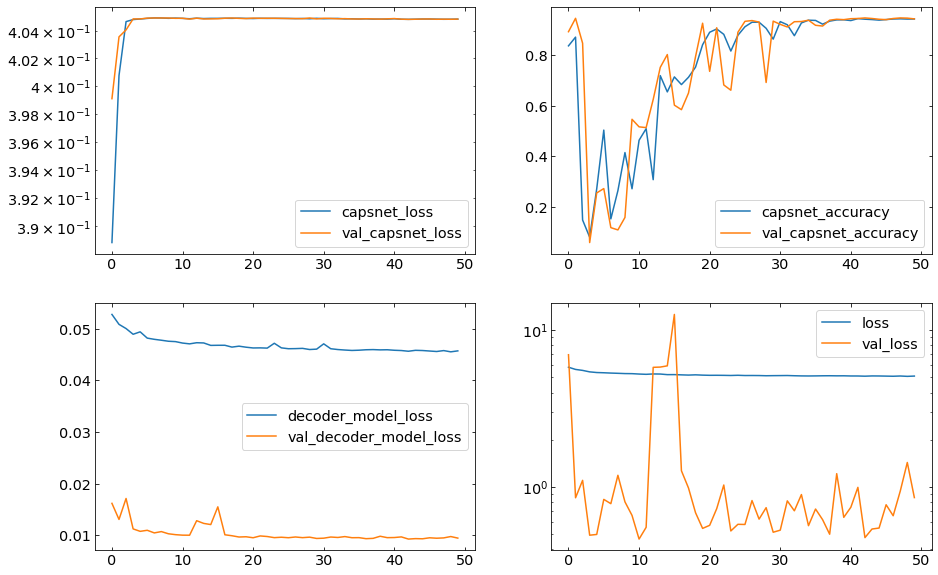

In [38]:
fig, axs = plt.subplots(2,2, figsize=(15,10))

axs[0,0].plot(log["epoch"], log["capsnet_loss"], label="capsnet_loss")
axs[0,0].plot(log["epoch"], log["val_capsnet_loss"], label = "val_capsnet_loss")
axs[0,0].set_yscale("log")
axs[0,0].legend()

axs[0,1].plot(log["epoch"], log["capsnet_accuracy"], label="capsnet_accuracy")
axs[0,1].plot(log["epoch"], log["val_capsnet_accuracy"], label = "val_capsnet_accuracy")
axs[0,1].legend()

axs[1,0].plot(log["epoch"], log["decoder_model_loss"], label="decoder_model_loss")
axs[1,0].plot(log["epoch"], log["val_decoder_model_loss"], label = "val_decoder_model_loss")
axs[1,0].legend()

axs[1,1].plot(log["epoch"], log["loss"], label="loss")
axs[1,1].plot(log["epoch"], log["val_loss"], label = "val_loss")
axs[1,1].set_yscale("log")
axs[1,1].legend()

In [16]:
print(f"Best epoch: {np.argmax(log.val_capsnet_accuracy)+1}")

Best epoch: 43


In [33]:
# this wont be needed in future
checkpoint_eval = 42
manipulate_model.load_weights(
    path_results / "weights" / f"weights-{checkpoint_eval:02d}.h5", by_name=True
)

In [34]:
x_test = data["test_img"]

In [35]:
y_caps_dev, y_caps_all_dev, y_prob_dev, x_recon_dev = eval_model.predict(x_dev,batch_size=128)
y_caps_test, y_caps_all_test, y_prob_test, x_recon_test = eval_model.predict(x_test,batch_size=128)

In [36]:
# normalise the probabilities
# norm_y_prob_train = y_prob_train / y_prob_train.sum(axis=-1, keepdims=True)
norm_y_prob_dev = y_prob_dev / y_prob_dev.sum(axis=-1, keepdims=True)
norm_y_prob_test = y_prob_test / y_prob_test.sum(axis=-1, keepdims=True)

Text(0.5, 1.0, 'uncalibrated classifier')

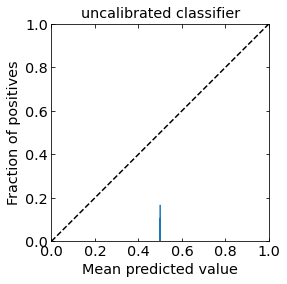

In [31]:
fig, ax = plt.subplots(1,1)
prob_true1, prob_pred1 = calibration_curve(np.argmax(y_dev, axis=-1), norm_y_prob_dev[:,1], n_bins=20, strategy="quantile")
ax.plot(prob_pred1,prob_true1)
e = np.linspace(0,1,20)
ax.plot(e,e,"k--")
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.set_xlabel("Mean predicted value")
ax.set_ylabel("Fraction of positives")
ax.set_aspect("equal")
ax.set_title("uncalibrated classifier")

(array([  2.,   0.,   0.,   1.,   0.,   2.,   0.,   1.,   2.,   1.,   0.,
          3.,   1.,   3.,   1.,   2.,   4.,   4.,   4.,   7.,   6.,  24.,
         43., 249., 230., 158.,  98.,  88.,  64., 224.,  33.,  42.,  16.,
         10.,   2.,   9.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([0.49990076, 0.4999036 , 0.49990642, 0.49990925, 0.49991208,
        0.4999149 , 0.49991775, 0.49992055, 0.49992338, 0.4999262 ,
        0.49992904, 0.49993187, 0.4999347 , 0.49993753, 0.49994037,
        0.4999432 , 0.49994603, 0.49994886, 0.4999517 , 0.4999545 ,
        0.49995732, 0.49996015, 0.499963  , 0.49996582, 0.49996865,
        0.49997148, 0.4999743 , 0.49997714, 0.49997997, 0.4999828 ,
        0.49998564, 0.49998847, 0.49999127, 0.4999941 , 0.49999693,
        0.49999976, 0.5000026 , 0.5000054 , 0.5000082 , 0.5000111 ,
        0.5000139 , 0.50001675, 0.50001955, 0.5000224 , 0.5000252 ,
        0.5000281 , 0.5000309 , 0.50003374, 0.

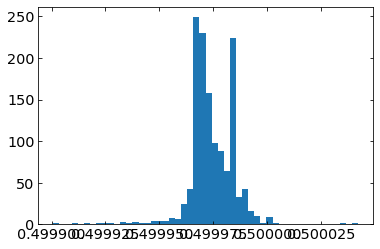

In [32]:
plt.hist(norm_y_prob_dev[:,1], bins=50)